In [52]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import requests
from bs4 import BeautifulSoup as bs
import zipfile
import io
import json
import itertools
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


* Set the type of 'deadline', 'launched' as datetime type in pandas

In [53]:
url = "https://webrobots.io/kickstarter-datasets/"
response = requests.get(url)
soup = bs(response.content, "html.parser")
csv_links = []

# Find links to CSV files
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.zip'):
        filename = href.split("/")[-1]
        date_str = filename.split("_")[1]
        if date_str >= "2020-12":
            csv_links.append(href)

# Download and process CSV files
dfs = []
for link in csv_links:
    response = requests.get(link)
    zip_file = io.BytesIO(response.content)
    # Extract CSV files from the zip archive and load them into pandas dataframes
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        csv_files = [name for name in zip_ref.namelist() if name.endswith('.csv')]
        for csv_file in csv_files:
            with zip_ref.open(csv_file) as file:
                df = pd.read_csv(file)
                df = df.rename(columns={'goal': 'goal_usd'})
                # Keep only the desired columns
                columns_to_keep = [ 'id','launched_at', 'backers_count','country','state', 'usd_pledged', 'category','goal_usd','currency', 'deadline']
                df = df[columns_to_keep]
                # Convert date columns to datetime
                df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')
                df['deadline'] = pd.to_datetime(df['deadline'], unit='s')
                
                
            dfs.append(df)

# Concatenate all dataframes into one
df_webrobot = pd.concat(dfs)

In [54]:
def get_category_name(json_str):
    data = json.loads(json_str)
    return data.get('parent_name','unknown')

df_webrobot['category'] = df_webrobot['category'].apply(get_category_name)

In [55]:
df_webrobot

,id,launched_at,backers_count,country,state,usd_pledged,category,goal_usd,currency,deadline
0,1458354567,2023-06-04 22:00:53,1,IT,live,1.071352,Publishing,2500.0,EUR,2023-07-04 22:00:53
1,2023568837,2023-06-01 12:57:38,70,US,live,10125.000000,Publishing,50000.0,USD,2023-07-31 12:57:38
2,952585495,2023-05-20 23:01:44,137,GB,live,18984.484555,Publishing,15000.0,GBP,2023-06-19 11:59:00
3,2056946610,2023-05-12 16:45:33,4,US,live,41.000000,Publishing,80000.0,USD,2023-07-11 16:45:33
4,1173092670,2023-05-08 10:25:06,226,US,live,19209.000000,Publishing,50000.0,USD,2023-06-09 03:59:00
...,...,...,...,...,...,...,...,...,...,...
3145,1438234172,2017-05-31 17:37:07,1,US,failed,10.000000,Publishing,500.0,USD,2017-07-15 17:37:07
3146,906168648,2015-01-28 16:43:38,6,GB,failed,244.588849,Film & Video,30000.0,GBP,2015-03-19 15:43:38
3147,708119891,2017-07-29 03:07:34,5,MX,canceled,287.559221,Food,350000.0,MXN,2017-09-15 15:00:00
3148,239852131,2015-08-30 21:17:44,51,GB,successful,1683.874823,Music,1000.0,GBP,2015-09-24 21:17:44


In [56]:
df_webrobot['duration'] = df_webrobot['deadline'] - df_webrobot['launched_at']

In [57]:
df_webrobot

,id,launched_at,backers_count,country,state,usd_pledged,category,goal_usd,currency,deadline,duration
0,1458354567,2023-06-04 22:00:53,1,IT,live,1.071352,Publishing,2500.0,EUR,2023-07-04 22:00:53,30 days 00:00:00
1,2023568837,2023-06-01 12:57:38,70,US,live,10125.000000,Publishing,50000.0,USD,2023-07-31 12:57:38,60 days 00:00:00
2,952585495,2023-05-20 23:01:44,137,GB,live,18984.484555,Publishing,15000.0,GBP,2023-06-19 11:59:00,29 days 12:57:16
3,2056946610,2023-05-12 16:45:33,4,US,live,41.000000,Publishing,80000.0,USD,2023-07-11 16:45:33,60 days 00:00:00
4,1173092670,2023-05-08 10:25:06,226,US,live,19209.000000,Publishing,50000.0,USD,2023-06-09 03:59:00,31 days 17:33:54
...,...,...,...,...,...,...,...,...,...,...,...
3145,1438234172,2017-05-31 17:37:07,1,US,failed,10.000000,Publishing,500.0,USD,2017-07-15 17:37:07,45 days 00:00:00
3146,906168648,2015-01-28 16:43:38,6,GB,failed,244.588849,Film & Video,30000.0,GBP,2015-03-19 15:43:38,49 days 23:00:00
3147,708119891,2017-07-29 03:07:34,5,MX,canceled,287.559221,Food,350000.0,MXN,2017-09-15 15:00:00,48 days 11:52:26
3148,239852131,2015-08-30 21:17:44,51,GB,successful,1683.874823,Music,1000.0,GBP,2015-09-24 21:17:44,25 days 00:00:00


In [58]:
df_kaggle =pd.read_csv('Kickstarter Campaigns DataSet.csv' , index_col=0)
df_kaggle = df_kaggle[['id', 'currency', 'launched_at', 'backers_count', 
       'country', 'deadline',  'status', 'usd_pledged', 'sub_category',
        'goal_usd']]
df_kaggle

,id,currency,launched_at,backers_count,country,deadline,status,usd_pledged,sub_category,goal_usd
0,1714728788,CAD,2018-02-10 22:47:52,16,CA,2018-04-11 21:47:52,failed,577.902078,food,785.82065
1,1639965256,USD,2014-11-21 10:42:26,7,US,2014-12-15 10:42:26,successful,211.000000,publishing,93.00000
2,1582062943,USD,2020-10-19 05:26:59,99,US,2020-11-18 05:26:59,successful,4697.000000,food,1500.00000
3,1888984372,USD,2019-05-29 16:01:34,3,US,2019-07-28 16:01:34,failed,222.000000,technology,25000.00000
4,1409770586,USD,2015-11-19 20:36:01,100,US,2015-12-19 20:36:01,successful,5410.000000,publishing,5000.00000
...,...,...,...,...,...,...,...,...,...,...
217248,1438234172,USD,2017-05-31 17:37:07,1,US,2017-07-15 17:37:07,failed,10.000000,publishing,500.00000
217249,906168648,GBP,2015-01-28 16:43:38,6,GB,2015-03-19 15:43:38,failed,244.588849,film & video,40621.01400
217250,708119891,MXN,2017-07-29 03:07:34,5,MX,2017-09-15 15:00:00,canceled,287.559221,food,17662.55400
217251,239852131,GBP,2015-08-30 21:17:44,51,GB,2015-09-24 21:17:44,successful,1683.874823,music,1354.03380


In [59]:
df_kaggle['launched_at'] = pd.to_datetime(df_kaggle['launched_at'])
df_kaggle['deadline'] = pd.to_datetime(df_kaggle['deadline'] )

In [60]:
df_kaggle['duration'] = df_kaggle['deadline'] - df_kaggle['launched_at']

In [61]:
df_kaggle = df_kaggle.rename(columns={'status': 'state', 'sub_category': 'category'})
df_kaggle['category'] = df_kaggle['category'].str.capitalize()
df_kaggle

,id,currency,launched_at,backers_count,country,deadline,state,usd_pledged,category,goal_usd,duration
0,1714728788,CAD,2018-02-10 22:47:52,16,CA,2018-04-11 21:47:52,failed,577.902078,Food,785.82065,59 days 23:00:00
1,1639965256,USD,2014-11-21 10:42:26,7,US,2014-12-15 10:42:26,successful,211.000000,Publishing,93.00000,24 days 00:00:00
2,1582062943,USD,2020-10-19 05:26:59,99,US,2020-11-18 05:26:59,successful,4697.000000,Food,1500.00000,30 days 00:00:00
3,1888984372,USD,2019-05-29 16:01:34,3,US,2019-07-28 16:01:34,failed,222.000000,Technology,25000.00000,60 days 00:00:00
4,1409770586,USD,2015-11-19 20:36:01,100,US,2015-12-19 20:36:01,successful,5410.000000,Publishing,5000.00000,30 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
217248,1438234172,USD,2017-05-31 17:37:07,1,US,2017-07-15 17:37:07,failed,10.000000,Publishing,500.00000,45 days 00:00:00
217249,906168648,GBP,2015-01-28 16:43:38,6,GB,2015-03-19 15:43:38,failed,244.588849,Film & video,40621.01400,49 days 23:00:00
217250,708119891,MXN,2017-07-29 03:07:34,5,MX,2017-09-15 15:00:00,canceled,287.559221,Food,17662.55400,48 days 11:52:26
217251,239852131,GBP,2015-08-30 21:17:44,51,GB,2015-09-24 21:17:44,successful,1683.874823,Music,1354.03380,25 days 00:00:00


In [62]:
df = pd.concat([df_webrobot, df_kaggle], axis=0)
df['category'] = df['category'].str.lower().str.strip()
df= df.rename(columns={'launched_at': 'launched', 'sub_category': 'category' , 'backers_count':'backers', 'usd_pledged': 'pledged' , 'goal_usd' : 'goal'})
df

,id,launched,backers,country,state,pledged,category,goal,currency,deadline,duration
0,1458354567,2023-06-04 22:00:53,1,IT,live,1.071352,publishing,2500.0000,EUR,2023-07-04 22:00:53,30 days 00:00:00
1,2023568837,2023-06-01 12:57:38,70,US,live,10125.000000,publishing,50000.0000,USD,2023-07-31 12:57:38,60 days 00:00:00
2,952585495,2023-05-20 23:01:44,137,GB,live,18984.484555,publishing,15000.0000,GBP,2023-06-19 11:59:00,29 days 12:57:16
3,2056946610,2023-05-12 16:45:33,4,US,live,41.000000,publishing,80000.0000,USD,2023-07-11 16:45:33,60 days 00:00:00
4,1173092670,2023-05-08 10:25:06,226,US,live,19209.000000,publishing,50000.0000,USD,2023-06-09 03:59:00,31 days 17:33:54
...,...,...,...,...,...,...,...,...,...,...,...
217248,1438234172,2017-05-31 17:37:07,1,US,failed,10.000000,publishing,500.0000,USD,2017-07-15 17:37:07,45 days 00:00:00
217249,906168648,2015-01-28 16:43:38,6,GB,failed,244.588849,film & video,40621.0140,GBP,2015-03-19 15:43:38,49 days 23:00:00
217250,708119891,2017-07-29 03:07:34,5,MX,canceled,287.559221,food,17662.5540,MXN,2017-09-15 15:00:00,48 days 11:52:26
217251,239852131,2015-08-30 21:17:44,51,GB,successful,1683.874823,music,1354.0338,GBP,2015-09-24 21:17:44,25 days 00:00:00


In [63]:
# Create a timestamp for January 1st, 2010
start_date = pd.Timestamp('2010-01-01')

# Filter the dataframe to only include rows where launched_at is after or equal to start_date
df = df[df['launched'] >= start_date]

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354586 entries, 0 to 217252
Data columns (total 11 columns):
 #   Column    Dtype          
---  ------    -----          
 0   id        int64          
 1   launched  datetime64[ns] 
 2   backers   int64          
 3   country   object         
 4   state     object         
 5   pledged   float64        
 6   category  object         
 7   goal      float64        
 8   currency  object         
 9   deadline  datetime64[ns] 
 10  duration  timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(4), timedelta64[ns](1)
memory usage: 215.6+ MB


In [65]:
unknown_count = df[df['category'] == 'unknown'].shape[0]
print(f"Number of projects 'unknown': {unknown_count}")

Number of projects 'unknown': 77645


In [66]:
df.drop(df[df['category'] == 'unknown'].index, inplace=True)

C:\Users\ilyes\AppData\Local\Temp\ipykernel_2676\1790586571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['category'] == 'unknown'].index, inplace=True)


### Target
* drop live
* set successful as 1
* set the rest as 0

In [67]:
df.groupby('state')['id'].count()

state
canceled        9107
failed         75116
live            5039
successful    124129
Name: id, dtype: int64

In [71]:
df = df.drop(df[df.state == "live"].index)
df.groupby('state')['id'].count()

state
canceled        9106
failed         75100
successful    124118
Name: id, dtype: int64

In [73]:
mapping = {"canceled": 0 , "failed" : 0, "successful": 1}
df["outcome"] = df["state"].map(mapping)

In [74]:
(df.groupby('outcome')['id'].count())

outcome
0     84206
1    124118
Name: id, dtype: int64

<AxesSubplot:>

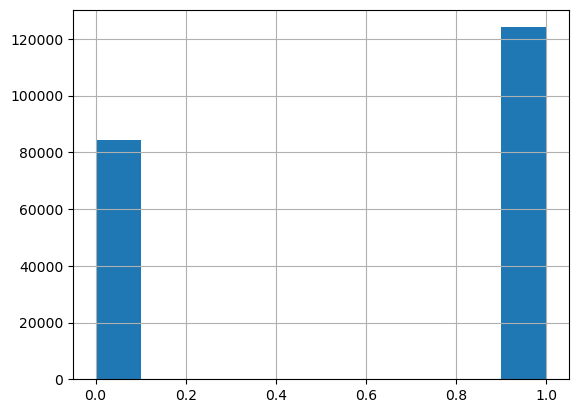

In [75]:
df["outcome"].hist()

### Categorical data

In [76]:
from sklearn.preprocessing import LabelEncoder
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = df[cat_features].apply(encoder.fit_transform)
encoded.head()

,category,currency,country
3697,10,14,24
3698,10,14,24
3699,10,14,24
3700,10,5,9
3701,10,14,24


In [77]:
df = df.drop(df[cat_features], axis = 1)
df.head()

,id,launched,backers,state,pledged,goal,deadline,duration,outcome
3697,147396963,2014-12-17 06:06:21,1,failed,11.000000,3000.0,2015-01-16 06:06:21,30 days 00:00:00,0
3698,1733242035,2014-12-01 17:28:50,1,failed,10.000000,2000.0,2014-12-31 17:28:50,30 days 00:00:00,0
3699,1078210323,2014-11-21 07:19:28,1,failed,1.000000,5000.0,2014-12-31 08:00:00,40 days 00:40:32,0
3700,1197177698,2014-11-16 03:12:58,2,failed,14.109325,150.0,2015-01-15 03:12:58,60 days 00:00:00,0
3701,1360650376,2014-11-10 22:05:26,13,failed,1045.000000,2000.0,2014-12-10 22:05:26,30 days 00:00:00,0


In [78]:
df = pd.concat([df, encoded], axis = 1)

In [79]:

df = df.assign(hour=df.launched.dt.hour,
               day=df.launched.dt.day,
               month=df.launched.dt.month,
               year=df.launched.dt.year)
df

,id,launched,backers,state,pledged,goal,deadline,duration,outcome,category,currency,country,hour,day,month,year
3697,147396963,2014-12-17 06:06:21,1,failed,11.000000,3000.0000,2015-01-16 06:06:21,30 days 00:00:00,0,10,14,24,6,17,12,2014
3698,1733242035,2014-12-01 17:28:50,1,failed,10.000000,2000.0000,2014-12-31 17:28:50,30 days 00:00:00,0,10,14,24,17,1,12,2014
3699,1078210323,2014-11-21 07:19:28,1,failed,1.000000,5000.0000,2014-12-31 08:00:00,40 days 00:40:32,0,10,14,24,7,21,11,2014
3700,1197177698,2014-11-16 03:12:58,2,failed,14.109325,150.0000,2015-01-15 03:12:58,60 days 00:00:00,0,10,5,9,3,16,11,2014
3701,1360650376,2014-11-10 22:05:26,13,failed,1045.000000,2000.0000,2014-12-10 22:05:26,30 days 00:00:00,0,10,14,24,22,10,11,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217248,1438234172,2017-05-31 17:37:07,1,failed,10.000000,500.0000,2017-07-15 17:37:07,45 days 00:00:00,0,12,14,24,17,31,5,2017
217249,906168648,2015-01-28 16:43:38,6,failed,244.588849,40621.0140,2015-03-19 15:43:38,49 days 23:00:00,0,6,5,9,16,28,1,2015
217250,708119891,2017-07-29 03:07:34,5,canceled,287.559221,17662.5540,2017-09-15 15:00:00,48 days 11:52:26,0,7,8,16,3,29,7,2017
217251,239852131,2015-08-30 21:17:44,51,successful,1683.874823,1354.0338,2015-09-24 21:17:44,25 days 00:00:00,1,10,5,9,21,30,8,2015


In [80]:
df = df[['goal', 'hour', 'day', 'month', 'year', 'category', 'currency', 'country', 'outcome']]
df

,goal,hour,day,month,year,category,currency,country,outcome
3697,3000.0000,6,17,12,2014,10,14,24,0
3698,2000.0000,17,1,12,2014,10,14,24,0
3699,5000.0000,7,21,11,2014,10,14,24,0
3700,150.0000,3,16,11,2014,10,5,9,0
3701,2000.0000,22,10,11,2014,10,14,24,0
...,...,...,...,...,...,...,...,...,...
217248,500.0000,17,31,5,2017,12,14,24,0
217249,40621.0140,16,28,1,2015,6,5,9,0
217250,17662.5540,3,29,7,2017,7,8,16,0
217251,1354.0338,21,30,8,2015,10,5,9,1


# Training test split

In [81]:
# Remove rows with missing values
df = df.dropna()

# Training test split
X = df[['goal', 'hour', 'day', 'month', 'year', 'category', 'currency', 'country']]
y = df["outcome"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


In [ ]:
df

,goal,hour,day,month,year,category,currency,country,outcome
3697,3000.0000,6,17,12,2014,10,14,24,0
3698,2000.0000,17,1,12,2014,10,14,24,0
3699,5000.0000,7,21,11,2014,10,14,24,0
3700,150.0000,3,16,11,2014,10,5,9,0
3701,2000.0000,22,10,11,2014,10,14,24,0
...,...,...,...,...,...,...,...,...,...
217248,500.0000,17,31,5,2017,12,14,24,0
217249,40621.0140,16,28,1,2015,6,5,9,0
217250,17662.5540,3,29,7,2017,7,8,16,0
217251,1354.0338,21,30,8,2015,10,5,9,1


## Training


In [82]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 100
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

c:\Users\ilyes\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ilyes\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 99294, number of negative: 67365
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 166659, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.595791 -> initscore=0.387960
[LightGBM] [Info] Start training from score 0.387960


### Evaluation


In [83]:
from sklearn import metrics
ypred = bst.predict(X_test)
score = metrics.roc_auc_score(y_test, ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.7927350594381225


In [84]:
ypred.shape

(41665,)

In [85]:
from sklearn.metrics import roc_curve, auc , roc_auc_score
from matplotlib import pyplot

lr_fpr, lr_tpr, _ = roc_curve(y_test, ypred)

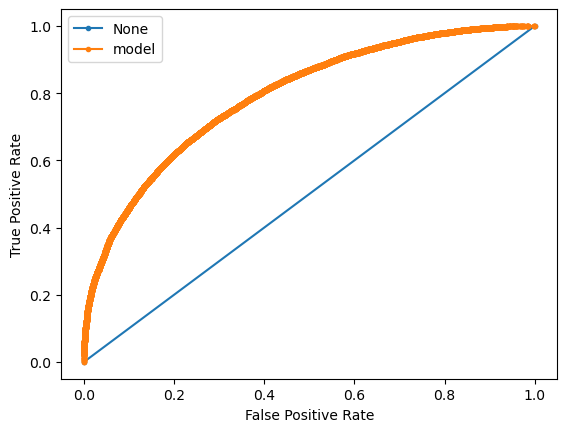

In [86]:
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

pyplot.plot(ns_fpr, ns_tpr, marker='.', label='None')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### 2) Count encodings

Here, encode the categorical features `['category', 'currency', 'country']` using the count of each value in the data set. Using `CountEncoder` from the `category_encoders` library, fit the encoding using the categorical feature columns defined in `cat_features`. Then apply the encodings to the train and validation sets, adding them as new columns with names suffixed `"_count"`.

In [87]:
import category_encoders as ce

In [88]:
cat_features = ['category', 'currency', 'country']
count_enc = ce.CountEncoder(cols=cat_features)
count_enc.fit(X_train[cat_features])

CountEncoder(cols=['category', 'currency', 'country'],
             combine_min_nan_groups=True)

In [89]:
train_encoded = X_train.join(count_enc.transform(X_train[cat_features]).add_suffix('_count'))
valid_encoded = X_test.join(count_enc.transform(X_test[cat_features]).add_suffix('_count'))

In [90]:
valid_encoded.head()

,goal,hour,day,month,year,category,currency,country,category_count,currency_count,country_count
3697,3000.0,6,17,12,2014,10,14,24,22054,114089,114089
3698,500.0,1,28,1,2015,10,14,24,22054,114089,114089
3698,500.0,1,28,1,2015,10,14,24,17101,114089,114089
3698,8000.0,4,2,10,2011,0,14,24,22054,114089,114089
3698,8000.0,4,2,10,2011,0,14,24,17101,114089,114089


# Train the model on the encoded dataset

In [91]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Define the categorical columns to be encoded
cat_columns = ['category', 'currency', 'country']

# Perform one-hot encoding on the training set
X_train_encoded = pd.get_dummies(X_train, columns=cat_columns)

# Perform one-hot encoding on the test set
X_test_encoded = pd.get_dummies(X_test, columns=cat_columns)

# Create an instance of the LogisticRegression model
logreg = LogisticRegression()

# Train the model on the encoded training data
logreg.fit(X_train_encoded, y_train)

# Predict on the encoded test data
y_pred = logreg.predict(X_test_encoded)

# Evaluate the model
accuracy = logreg.score(X_test_encoded, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.6425537021480859


### 4) Target encoding

* supervised encodings that use the labels (the targets) to transform categorical features. 
* Target encoding replaces a categorical value with the average value of the target for that value of the feature. 

In [92]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']
# Create the encoder itself
target_enc = ce.TargetEncoder(cols=cat_features)
# Fit the encoder using the categorical features and target
target_enc.fit(X_train[cat_features], y_train)

train_encoded = X_train.join(target_enc.transform(X_train[cat_features]).add_suffix('_target'))
valid_encoded = X_test.join(target_enc.transform(X_test[cat_features]).add_suffix('_target'))

train_encoded

,goal,hour,day,month,year,category,currency,country,category_target,currency_target,country_target
3697,3500.000000,18,7,4,2018,8,14,24,0.717732,0.603538,0.603538
3697,3500.000000,18,7,4,2018,8,14,24,0.717732,0.603538,0.603538
3697,3500.000000,18,7,4,2018,8,14,24,0.672064,0.603538,0.603538
3697,3500.000000,18,7,4,2018,8,14,24,0.594702,0.649032,0.649032
3697,3500.000000,18,7,4,2018,8,14,24,0.344023,0.603538,0.603538
...,...,...,...,...,...,...,...,...,...,...,...
217246,60823.921000,16,14,10,2014,8,4,17,0.717732,0.491814,0.476190
217247,336.671317,16,5,2,2020,6,5,9,0.595227,0.649032,0.649032
217248,500.000000,17,31,5,2017,12,14,24,0.672064,0.603538,0.603538
217249,40621.014000,16,28,1,2015,6,5,9,0.595227,0.649032,0.649032


### CatBoost Encoding
* This is similar to target encoding in that it's based on the target probablity for a given value. However with CatBoost, for each row, the target probability is calculated only from the rows before it.

In [93]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']
# Create the encoder itself
target_enc = ce.CatBoostEncoder(cols=cat_features)
# Fit the encoder using the categorical features and target
target_enc.fit(X_train[cat_features], y_train)

train_encoded = X_train.join(target_enc.transform(X_train[cat_features]).add_suffix('_cb'))
valid_encoded = X_test.join(target_enc.transform(X_test[cat_features]).add_suffix('_cb'))

train_encoded

,goal,hour,day,month,year,category,currency,country,category_cb,currency_cb,country_cb
3697,3500.000000,18,7,4,2018,8,14,24,0.717720,0.603538,0.603538
3697,3500.000000,18,7,4,2018,8,14,24,0.717720,0.603538,0.603538
3697,3500.000000,18,7,4,2018,8,14,24,0.672059,0.603538,0.603538
3697,3500.000000,18,7,4,2018,8,14,24,0.594702,0.649029,0.649029
3697,3500.000000,18,7,4,2018,8,14,24,0.344076,0.603538,0.603538
...,...,...,...,...,...,...,...,...,...,...,...
217246,60823.921000,16,14,10,2014,8,4,17,0.717720,0.491822,0.476273
217247,336.671317,16,5,2,2020,6,5,9,0.595227,0.649029,0.649029
217248,500.000000,17,31,5,2017,12,14,24,0.672059,0.603538,0.603538
217249,40621.014000,16,28,1,2015,6,5,9,0.595227,0.649029,0.649029


# Creating new features from the raw data 

* start over..

In [95]:
df = pd.read_csv("df.csv")

In [96]:
interactions = df['category'] + "_" + df['country']
print(interactions.head(10))

0    music_US
1    music_US
2    music_US
3    music_GB
4    music_US
5    music_US
6    music_US
7    music_US
8    music_US
9    music_US
dtype: object


In [97]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
df = df.assign(category_country=label_enc.fit_transform(interactions))
df.head()

,id,launched,backers,country,state,pledged,category,goal,currency,deadline,duration,category_country
0,147396963,2014-12-17 06:06:21,1,US,failed,11.000000,music,3000.0,USD,2015-01-16 06:06:21,30 days 00:00:00,248
1,1733242035,2014-12-01 17:28:50,1,US,failed,10.000000,music,2000.0,USD,2014-12-31 17:28:50,30 days 00:00:00,248
2,1078210323,2014-11-21 07:19:28,1,US,failed,1.000000,music,5000.0,USD,2014-12-31 08:00:00,40 days 00:40:32,248
3,1197177698,2014-11-16 03:12:58,2,GB,failed,14.109325,music,150.0,GBP,2015-01-15 03:12:58,60 days 00:00:00,235
4,1360650376,2014-11-10 22:05:26,13,US,failed,1045.000000,music,2000.0,USD,2014-12-10 22:05:26,30 days 00:00:00,248


In [98]:
launched = pd.Series(df.index, index=df.launched, name="count_7_days").sort_index()
launched.head(20)

launched
2010-01-03 01:08:07     15035
2010-01-03 11:34:04    195469
2010-01-04 02:55:23     19267
2010-01-04 05:33:28     75914
2010-01-04 20:38:06     16472
2010-01-05 16:54:04     77340
2010-01-05 17:17:06     94469
2010-01-05 21:53:18    187367
2010-01-07 17:47:02    183029
2010-01-07 22:28:04     18431
2010-01-07 22:47:25    155982
2010-01-09 05:33:22     37314
2010-01-09 07:34:14    202269
2010-01-09 21:52:31    109247
2010-01-09 22:46:08    175476
2010-01-10 02:56:07     98337
2010-01-10 18:48:58     62446
2010-01-13 05:32:17    179837
2010-01-13 05:48:23     13688
2010-01-13 16:34:40    164018
Name: count_7_days, dtype: int64

In [99]:
import matplotlib.pyplot as plt
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates the first 7 numbers..
plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

ValueError: window must be an integer 0 or greater

In [ ]:
count_7_days.index = launched.values  # launched.values  are the index
count_7_days = count_7_days.reindex(df.index)
count_7_days.head(10)

KeyboardInterrupt: 

In [ ]:
df = df.join(count_7_days)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,category_country,count_7_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,1906,1409.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,1635,957.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,1635,739.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,1600,907.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,983,1429.0


Do projects in the same category compete for donors? If you're trying to fund a video game and another game project was just launched, you might not get as much money. We can capture this by calculating the time since the last launch project in the same category.

* .groupby then .transform. The .transform method takes a function then passes a series or dataframe to that function for each group. This returns a dataframe with the same indices as the original dataframe. In our case, we'll perform a groupby on "category" and use transform to calculate the time differences for each category.

In [ ]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df_temp = df[['category', 'launched']].sort_values('launched')
df_temp.head()

,category,launched
75397,Film & Video,1970-01-01 01:00:00
319002,Publishing,1970-01-01 01:00:00
2842,Film & Video,1970-01-01 01:00:00
94579,Theater,1970-01-01 01:00:00
247913,Music,1970-01-01 01:00:00


In [ ]:

df_temp.groupby('category').count().head(10)

,launched
category,
3D Printing,683
Academic,916
Accessories,3165
Action,740
Animals,255
Animation,2541
Anthologies,784
Apparel,7166
Apps,6345


In [ ]:
timedeltas = df_temp.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
75397,NaN
319002,NaN
2842,0.000000
94579,NaN
247913,NaN
273779,NaN
48147,NaN
169268,NaN
322000,NaN
138572,NaN


We get NaNs here for projects that are the first in their category. We'll need to fill those in with something like the mean or median. We'll also need to reset the index so we can join it with the other data

In [ ]:
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(df.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


In [ ]:
df["competitionValue"] = timedeltas

In [ ]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,category_country,count_7_days,competitionValue
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,1906,1409.0,18.606111
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,1635,957.0,5.592778
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,1635,739.0,1.313611
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,1600,907.0,0.635000
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,983,1429.0,16.661389


# train test split again

In [ ]:
df = df.drop(df[df.state == "live"].index)
mapping = {"canceled": 0 , "failed" : 0, "suspended" : 0, "undefined": 0, "successful": 1}
df["outcome"] = df["state"].map(mapping)
from sklearn.preprocessing import LabelEncoder
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = df[cat_features].apply(encoder.fit_transform)
df = df.drop(df[cat_features], axis = 1)
df = pd.concat([df, encoded], axis = 1)
df = df.assign(hour=df.launched.dt.hour,
               day=df.launched.dt.day,
               month=df.launched.dt.month,
               year=df.launched.dt.year)
df.head()

,ID,name,main_category,deadline,goal,launched,pledged,state,backers,usd pledged,...,count_7_days,competitionValue,outcome,category,currency,country,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Publishing,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,0.0,...,1409.0,18.606111,0,108,5,9,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,100.0,...,957.0,5.592778,0,93,13,22,4,2,9,2017
2,1000004038,Where is Hank?,Film & Video,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,220.0,...,739.0,1.313611,0,93,13,22,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,1.0,...,907.0,0.635000,0,90,13,22,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,1283.0,...,1429.0,16.661389,0,55,13,22,8,4,7,2015


In [ ]:
X = df[['goal', 'hour', 'day', 'month', 'year', 'category', 'currency', 'country', 'category_country',
       'count_7_days', 'competitionValue']]
y = df["outcome"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [ ]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']
# Create the encoder itself
target_enc = ce.CatBoostEncoder(cols=cat_features)
# Fit the encoder using the categorical features and target
target_enc.fit(X_train[cat_features], y_train)

train_encoded = X_train.join(target_enc.transform(X_train[cat_features]).add_suffix('_cb'))
valid_encoded = X_test.join(target_enc.transform(X_test[cat_features]).add_suffix('_cb'))

train_encoded.head()

,goal,hour,day,month,year,category,currency,country,category_country,count_7_days,competitionValue,category_cb,currency_cb,country_cb
348042,500.0,17,22,10,2016,26,13,22,474,1100.0,40.546389,0.503093,0.372651,0.375853
270996,16000.0,2,23,8,2013,148,13,22,2575,779.0,1.168056,0.204468,0.372651,0.375853
159632,6000.0,21,14,3,2016,39,13,22,702,1271.0,2.616111,0.369402,0.372651,0.375853
155711,3000.0,21,15,6,2015,10,13,22,239,1606.0,0.232500,0.412317,0.372651,0.375853
89633,3500.0,21,8,7,2015,79,13,22,1418,1444.0,143.311944,0.478017,0.372651,0.375853


# Train

In [ ]:
import lightgbm as lgb

dtrain = lgb.Dataset(train_encoded, label=y_train)
dvalid = lgb.Dataset(valid_encoded, label=y_test)

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 100
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)
ypred = bst.predict(valid_encoded)
score = metrics.roc_auc_score(y_test, ypred)
print (score)

0.7455930106961035


# feature selections

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
# Keep 5 features
selector = SelectKBest(f_classif, k=5)
X_new = selector.fit_transform(train_encoded, y_train)
X_new

array([[2.01600000e+03, 1.10000000e+03, 5.03092701e-01, 3.72650657e-01,
        3.75853372e-01],
       [2.01300000e+03, 7.79000000e+02, 2.04467630e-01, 3.72650657e-01,
        3.75853372e-01],
       [2.01600000e+03, 1.27100000e+03, 3.69401610e-01, 3.72650657e-01,
        3.75853372e-01],
       ...,
       [2.01600000e+03, 9.54000000e+02, 4.09381691e-01, 3.72650657e-01,
        3.75853372e-01],
       [2.01200000e+03, 7.06000000e+02, 2.77410622e-01, 3.72650657e-01,
        3.75853372e-01],
       [2.01500000e+03, 1.02300000e+03, 2.57105113e-01, 3.72650657e-01,
        3.75853372e-01]])

In [ ]:
# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train_encoded.index, 
                                 columns=train_encoded.columns)
selected_features.head()

,goal,hour,day,month,year,category,currency,country,category_country,count_7_days,competitionValue,category_cb,currency_cb,country_cb
348042,0.0,0.0,0.0,0.0,2016.0,0.0,0.0,0.0,0.0,1100.0,0.0,0.503093,0.372651,0.375853
270996,0.0,0.0,0.0,0.0,2013.0,0.0,0.0,0.0,0.0,779.0,0.0,0.204468,0.372651,0.375853
159632,0.0,0.0,0.0,0.0,2016.0,0.0,0.0,0.0,0.0,1271.0,0.0,0.369402,0.372651,0.375853
155711,0.0,0.0,0.0,0.0,2015.0,0.0,0.0,0.0,0.0,1606.0,0.0,0.412317,0.372651,0.375853
89633,0.0,0.0,0.0,0.0,2015.0,0.0,0.0,0.0,0.0,1444.0,0.0,0.478017,0.372651,0.375853


In [ ]:
selected_columns = selected_features.columns[selected_features.var() != 0]
train_encoded[selected_columns].head()

,year,count_7_days,category_cb,currency_cb,country_cb
348042,2016,1100.0,0.503093,0.372651,0.375853
270996,2013,779.0,0.204468,0.372651,0.375853
159632,2016,1271.0,0.369402,0.372651,0.375853
155711,2015,1606.0,0.412317,0.372651,0.375853
89633,2015,1444.0,0.478017,0.372651,0.375853


In [ ]:
import lightgbm as lgb

dtrain = lgb.Dataset(train_encoded[selected_columns], label=y_train)
dvalid = lgb.Dataset(valid_encoded[selected_columns], label=y_test)

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 100
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)
ypred = bst.predict(valid_encoded[selected_columns])
score = metrics.roc_auc_score(y_test, ypred)
print (score)

0.6960739753901292


# L1 regularization
Univariate methods consider only one feature at a time when making a selection decision. Instead, we can make our selection using all of the features by including them in a linear model with L1 regularization. This type of regularization (sometimes called Lasso) penalizes the absolute magnitude of the coefficients, as compared to L2 (Ridge) regression which penalizes the square of the coefficients.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel



In [ ]:
# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7).fit(train_encoded, y_train)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(train_encoded)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
# Get back the features we've kept, zero out all other features
selected_features_2 = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train_encoded.index, 
                                 columns=train_encoded.columns)
selected_features_2.head()

,goal,hour,day,month,year,category,currency,country,category_country,count_7_days,competitionValue,category_cb,currency_cb,country_cb
348042,500.0,17.0,22.0,10.0,2016.0,26.0,13.0,22.0,474.0,1100.0,40.546389,0.503093,0.372651,0.375853
270996,16000.0,2.0,23.0,8.0,2013.0,148.0,13.0,22.0,2575.0,779.0,1.168056,0.204468,0.372651,0.375853
159632,6000.0,21.0,14.0,3.0,2016.0,39.0,13.0,22.0,702.0,1271.0,2.616111,0.369402,0.372651,0.375853
155711,3000.0,21.0,15.0,6.0,2015.0,10.0,13.0,22.0,239.0,1606.0,0.232500,0.412317,0.372651,0.375853
89633,3500.0,21.0,8.0,7.0,2015.0,79.0,13.0,22.0,1418.0,1444.0,143.311944,0.478017,0.372651,0.375853


In [ ]:
selected_columns = selected_features_2.columns[selected_features_2.var() != 0] # var() --> variance of columns
train_encoded[selected_columns].head()

,goal,hour,day,month,year,category,currency,country,category_country,count_7_days,competitionValue,category_cb,currency_cb,country_cb
348042,500.0,17,22,10,2016,26,13,22,474,1100.0,40.546389,0.503093,0.372651,0.375853
270996,16000.0,2,23,8,2013,148,13,22,2575,779.0,1.168056,0.204468,0.372651,0.375853
159632,6000.0,21,14,3,2016,39,13,22,702,1271.0,2.616111,0.369402,0.372651,0.375853
155711,3000.0,21,15,6,2015,10,13,22,239,1606.0,0.232500,0.412317,0.372651,0.375853
89633,3500.0,21,8,7,2015,79,13,22,1418,1444.0,143.311944,0.478017,0.372651,0.375853


In [ ]:
import lightgbm as lgb

dtrain = lgb.Dataset(train_encoded[selected_columns], label=y_train)
dvalid = lgb.Dataset(valid_encoded[selected_columns], label=y_test)

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 100
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)
ypred = bst.predict(valid_encoded[selected_columns])
score = metrics.roc_auc_score(y_test, ypred)
print (score)

0.7455930106961035


# extra 

* np.log transform the goal column